In [25]:
import sys
from multiprocessing import Pool, cpu_count
import importlib

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import sklearn.preprocessing
from sklearn.preprocessing import normalize
from astropy.coordinates import SkyCoord
import numba

plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

threads = min(100, cpu_count())

# Constants

In [2]:
detector = dict(innernum=16, outernum=15, ynum=1, chunk=6, phinum=8, width=2, film=0.1, interval=0.2, height=7, diameter=175)
image = dict(x=70, y=70, z=96, xnum=140, ynum=140, znum=120, xwidth=0.5, ywidth=0.5, zwidth=0.8)
image = dict(x=70, y=70, z=96, xnum=70, ynum=70, znum=60, xwidth=1., ywidth=1., zwidth=1.6)

In [3]:
x_pixels = np.arange(-image['xnum'] / 2 * image['xwidth'] + image['xwidth'] / 2, image['xnum'] / 2 * image['xwidth'] + image['xwidth'] / 2, image['xwidth'])

y_pixels = np.arange(-image['ynum'] / 2 * image['ywidth'] + image['ywidth'] / 2, image['ynum'] / 2 * image['ywidth'] + image['ywidth'] / 2, image['ywidth'])

z_pixels = np.arange(-image['znum'] / 2 * image['zwidth'] + image['zwidth'] / 2, image['znum'] / 2 * image['zwidth'] + image['zwidth'] / 2, image['zwidth'])

In [4]:
x_det_inner = detector['interval'] / 2 + np.arange((detector['width'] + detector['film']) / 2, detector['innernum'] * (detector['width'] + detector['film']), (detector['width'] + detector['film']))

x_det_inner = np.hstack([-1 * x_det_inner[::-1], x_det_inner])

x_det_outer = (detector['width'] + detector['film'] + detector['interval']) / 2 + np.arange((detector['width'] + detector['film']) / 2, detector['outernum'] * (detector['width'] + detector['film']), (detector['width'] + detector['film']))

x_det_outer = np.hstack([-1 * x_det_outer[::-1], x_det_outer])

In [5]:
y_det_inner = np.array([detector['diameter'] / 2])

y_det_outer = np.array([detector['diameter'] / 2 + detector['height']])

In [6]:
z_det_inner = np.arange(-detector['innernum'] / 2 * (detector['width'] + detector['film']) + (detector['width'] + detector['film']) / 2, 
                        detector['innernum'] / 2 * (detector['width'] + detector['film']) + (detector['width'] + detector['film']) / 2, (detector['width'] + detector['film']))

z_det_outer = np.linspace(0, (detector['width'] + detector['film']) * (detector['outernum'] - 1), detector['outernum']) - (detector['width'] + detector['film']) * (detector['outernum'] - 1) / 2

z_displace = detector['innernum'] * detector['width'] + (detector['innernum'] + 1) * detector['film'] + detector['interval']

z_det_inner = np.hstack([z_det_inner + i * z_displace for i in [-1, 0, 1]])

z_det_outer = np.hstack([z_det_outer + i * z_displace for i in [-1, 0, 1]])

In [7]:
x_wall_inner = x_det_inner + (detector['width'] + detector['film']) / 2

x_wall_outer = x_det_outer + (detector['width'] + detector['film']) / 2

y_wall_inner = y_det_inner + (detector['width'] + detector['film']) / 2

y_wall_outer = y_det_outer + (detector['width'] + detector['film']) / 2

z_wall_inner = z_det_inner + (detector['width'] + detector['film']) / 2

z_wall_outer = z_det_outer + (detector['width'] + detector['film']) / 2

In [8]:
R = np.vstack([np.array([[[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]]) for theta in np.arange(8) * np.pi / 4])

In [9]:
X_det_inner, Y_det_inner, Z_det_inner = np.meshgrid(x_det_inner, y_det_inner, z_det_inner)

X_det_outer, Y_det_outer, Z_det_outer = np.meshgrid(x_det_outer, y_det_outer, z_det_outer)

X_pixels, Y_pixels, Z_pixels = np.meshgrid(x_pixels, y_pixels, z_pixels)

xyz_pixels = np.vstack([X_pixels.flatten(), Y_pixels.flatten(), Z_pixels.flatten()]).T

In [10]:
x_pixels_wall = np.linspace(-image['x'] / 2, image['x'] / 2, image['xnum'] + 1)

y_pixels_wall = np.linspace(-image['y'] / 2, image['y'] / 2, image['ynum'] + 1)

z_pixels_wall = np.linspace(-image['z'] / 2, image['z'] / 2, image['znum'] + 1)

pixels_wall = [x_pixels_wall, y_pixels_wall, z_pixels_wall]

In [11]:
b = np.fromfile('LORData_2PointSource', dtype=np.float32)
# b = np.fromfile('LORData_HotRod39M', dtype=np.float32)

a = b.reshape((b.shape[0] // 7, 7))

# Transformation matrix

In [938]:
def trans_matrix(method='delta'):
    xyz_det_list = []
    if method == 'delta':
        matrix = np.zeros((detector['innernum'] ** 2 * detector['chunk'] * detector['phinum'], image['xnum'] * image['ynum'] * image['znum']))#.astype(np.float32)
        for i in tqdm(range(8)):
            xyz_det = (R[i] @ np.vstack([X_det_inner.flatten(), Y_det_inner.flatten(), Z_det_inner.flatten()])).T
            nhat = normalize(xyz_det)
            delta = xyz_det[:, None, :] - xyz_pixels
            mhat = delta / np.sqrt((delta ** 2).sum(axis=-1))[:, :, None]
            m = (nhat[:, None, :] * mhat).sum(axis=-1)
            # m = np.zeros((detector['outernum'] ** 2 * detector['chunk'], image['xnum'] * image['ynum'] * image['znum']))
            matrix[detector['innernum'] ** 2 * detector['chunk'] * i:detector['innernum'] ** 2 * detector['chunk'] * (i+1)] = m
            xyz_det_list.append(xyz_det)
    return matrix, xyz_det_list

In [939]:
m, xyz_det_list = trans_matrix()

100%|██████████| 8/8 [02:57<00:00, 22.16s/it]


In [941]:
xyz = np.hstack([np.vstack([a[:, 0:3], a[:, 3:6]]), np.hstack([a[:, 6] / 2, a[:, 6] / 2])[:, None]])

X = SkyCoord(x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2], representation_type='cartesian')
X.representation_type = 'physicsspherical'

theta = np.mod(X.phi.rad + 4 * np.pi + np.pi / 8 - np.pi / 2, 2 * np.pi)

p = np.zeros(m.shape[0])
index = np.ones(len(xyz)).astype(np.int16) * -2
det_num = detector['innernum'] ** 2 * 6

for i in tqdm(range(8)):
    vali = (theta > i * np.pi / 4) & (theta < (i + 1) * np.pi / 4)
    xyzi = (np.linalg.inv(R[i]) @ xyz[vali, :3].T).T
    inner = xyzi[:, 1] < y_det_inner * 1.01
    g = xyz[vali, -1]
    idx = np.ones(vali.sum()).astype(np.int16) * -1
    pi = np.zeros(det_num)
    x_idx = np.digitize(xyzi[inner, 0], x_wall_inner)
    assert x_idx.min() >= 0 and x_idx.max() < detector['innernum'] * 2
    y_idx = np.digitize(xyzi[inner, 1], y_wall_inner)
    assert y_idx.min() >= 0 and y_idx.max() < detector['ynum']
    z_idx = np.digitize(xyzi[inner, 2], z_wall_inner)
    assert z_idx.min() >= 0 and z_idx.max() < detector['innernum'] * 3
    idx[inner] = x_idx * detector['ynum'] * detector['innernum'] * 3 + y_idx * detector['innernum'] * 3 + z_idx
    for j in range(len(idx)):
        if g[j] > 0 and idx[j] >= 0:
            pi[idx[j]] += g[j]
    index[vali] = idx
    p[i*det_num:(i+1)*det_num] = pi

p = np.clip(p, 0, 1e6)

100%|██████████| 8/8 [01:05<00:00,  8.14s/it]


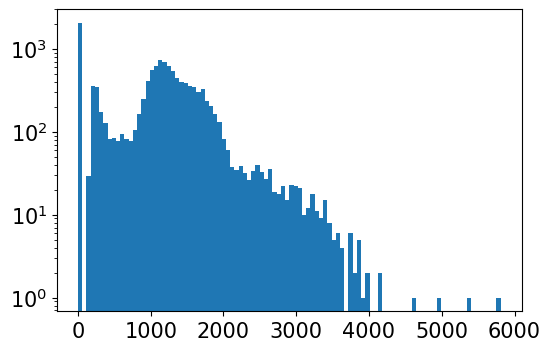

In [942]:
plt.hist(p, bins=100)
plt.yscale('log')
plt.show()

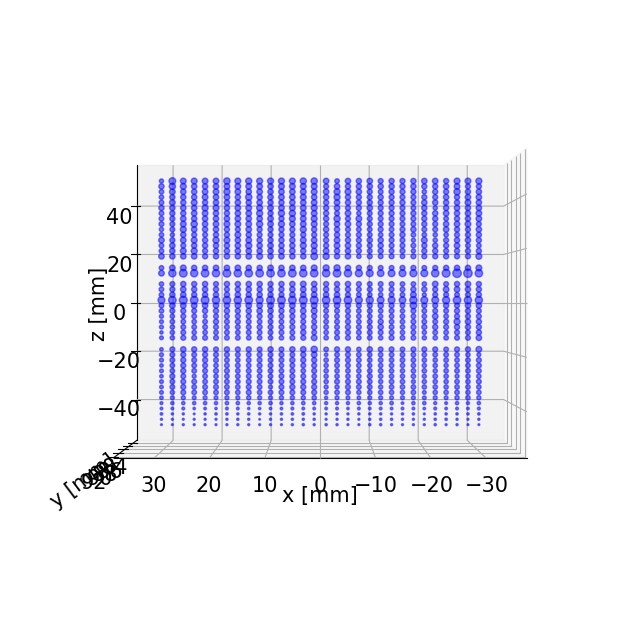

In [943]:
n = 1

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=0., azim=90.)
ax.scatter(X_det_inner.flatten(), Y_det_inner.flatten(), Z_det_inner.flatten(), color='b', s=p[n*X_det_inner.size:(n+1)*X_det_inner.size] * 0.01, alpha=0.5)    
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png'.format(i))

plt.show()

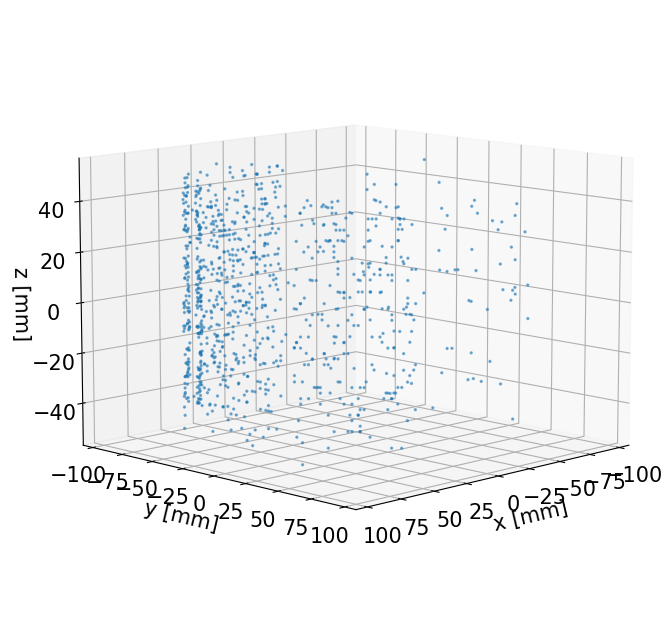

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=45.)
ax.scatter(a[:1000, 0], a[:1000, 1], a[:1000, 2], s=2.0, alpha=0.5)
# ax.scatter(a[:1000, 3], a[:1000, 4], a[:1000, 5], s=2.0, alpha=0.5)
# ax.plot([a[0, 0], a[0, 3]], [a[0, 1], a[0, 4]], [a[0, 2], a[0, 5]])
# for i in range(100):
#     ax.plot([a[i, 0], a[i, 3]], [a[i, 1], a[i, 4]], [a[i, 2], a[i, 5]])
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png'.format(i))

plt.show()

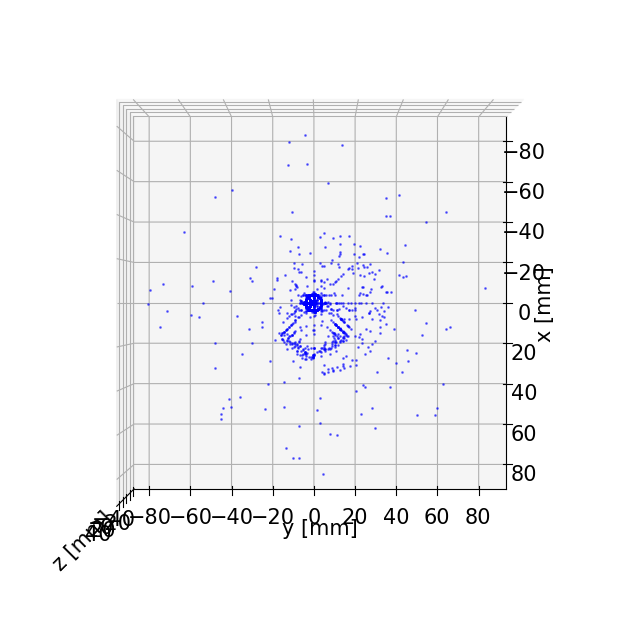

In [13]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=90., azim=0.)
for i in np.arange(0, a.shape[0], 10000):
    ax.scatter((a[i, 0] + a[i, 3]) / 2, (a[i, 1] + a[i, 4]) / 2, (a[i, 2] + a[i, 5]) / 2, color='b', s=1.0, alpha=0.5)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png'.format(i))

plt.show()

# OS-EM reconstruction

In [19]:
L_list = np.sort(np.hstack([2 ** np.arange(12), 2 ** np.arange(12) * 3]))[1:]
L = L_list[8]

f = np.full(m.shape[1], p.sum() / m.sum())
f_list = [f]
d_list = []
tiny = np.finfo(np.float32).tiny
D = m.shape[0] // L

for i in tqdm(range(50)):
    for j in range(L):
        f_t = f_list[-1] / (m[D*j:D*(j+1), :].sum(axis=0) + tiny) * (m[D*j:D*(j+1), :].T @ (p[D*j:D*(j+1)] / (m[D*j:D*(j+1), :] @ f_list[-1] + tiny)))
        f_list.append(f_t)
        d_list.append(np.abs(f_list[-2] - f_list[-1]).max())
        # if d_list[-1] < 1e-3:
        #     break

100%|██████████| 50/50 [05:20<00:00,  6.40s/it]


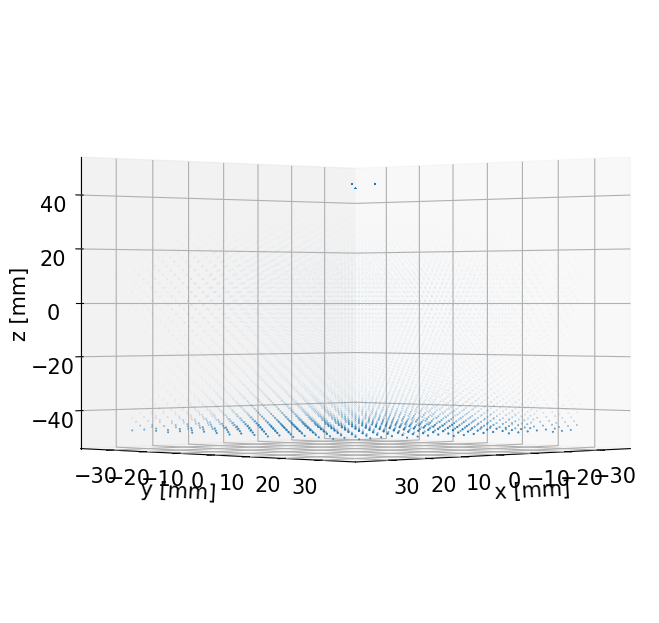

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=0., azim=45.)
vali = np.arange(0, X_pixels.size, X_pixels.size // 10000)
ax.scatter(X_pixels.flatten()[vali], Y_pixels.flatten()[vali], Z_pixels.flatten()[vali], s=f_list[-1][vali] * 2, alpha=1.0)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png'.format(i))

plt.show()

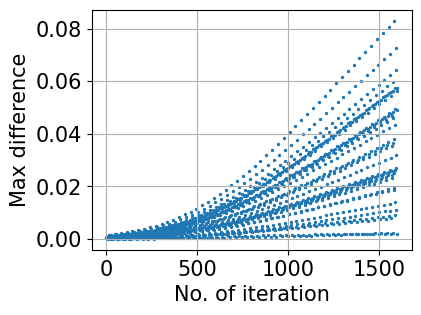

In [21]:
# gray = f_list[-1].reshape((image['xnum'], image['ynum'], image['znum']))
# plt.imshow(gray)
# plt.show()

fig = plt.figure(figsize=(4, 3))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(np.arange(len(d_list)), d_list, s=2.0)
# ax.plot(np.arange(len(d_list)), d_list, 'o-', markersize=4.0)
ax.grid()
ax.set_xlabel('No. of iteration')
ax.set_ylabel('Max difference')

plt.show()

# Siddon algorithm

In [275]:
all_num = image['xnum'] * image['ynum'] * image['znum']
x_num = np.array([[image['ynum'] * image['znum'], image['znum'], 1]]).T

In [341]:
t = np.array([-104.5, 35, -48 + 0.8, 35, -104.5, -48 + 0.8, 1])
t = np.array([-104, 35, -48 + 0.8, 35, -104, -48 + 0.8, 1])
t = np.array([-100, -100, -100, 100, 100, 100, 1])
t = np.array([-35 + 0.5, -35 + 0.5, -100, -35 + 0.5, -35 + 0.5, 100, 1])
t = np.array([-35.25, -34.25, -48 + 0.8, -34.25, -35.25, -48 + 0.8, 1])

In [342]:
@numba.njit
def sensitivity_map(t, pixels_wall):
    dim = 3
    d = 0
    for j in range(3):
        d += (t[j + dim] - t[j]) ** 2
    d = np.sqrt(d)
    d_frac = np.empty(0)
    dig_list = []
    dig_l = []
    for j, wall in enumerate(pixels_wall):
        x = [t[j], t[j+dim]]
        dig_list.append(np.digitize(x, wall))
        if dig_list[j][0] > dig_list[j][-1]:
            tl = np.arange(dig_list[j][-1], dig_list[j][0], 1)[::-1]
        else:
            tl = np.arange(dig_list[j][0], dig_list[j][-1], 1)
        dig_l.append(tl)
        x_list = pixels_wall[j][dig_l[j]]
        d_l = (x_list - t[j]) / (t[j+dim] - t[j]) * d
        d_frac = np.append(d_frac, d_l)
    x_init = np.array([[dig_list[j][0] - 1 for j in range(3)]]).T
    ll = np.array([0])
    for j in range(dim):
        ll = np.append(ll, len(dig_l[j]))
    ll = np.cumsum(ll)
    int_list = np.zeros((dim, ll[-1])).astype(np.int16)
    for j in range(dim):
        if dig_list[j][0] > dig_list[j][-1]:
            int_list[j, ll[j]:ll[j+1]] = -1
        elif dig_list[j][0] < dig_list[j][-1]:
            int_list[j, ll[j]:ll[j+1]] = 1
    x_delta = int_list[:, d_frac.argsort()][:, :-1]
    x_cumdelta = np.zeros((dim, ll[-1] - 1)).astype(np.int16)
    for j in range(dim):
        x_cumdelta[j] = np.cumsum(x_delta[j])
    x_dig = x_init + x_cumdelta
    pixels_dig_xyz = x_dig * x_num
    pixels_dig = np.sum(pixels_dig_xyz, axis=0)
    vali = np.full(x_dig.shape[1], True)
    for j, wall in enumerate(pixels_wall):
        vali &= ((x_dig[j] >= 0) & (x_dig[j] < len(wall) - 1))
    return pixels_dig[vali], np.diff(np.sort(d_frac))[vali]

In [343]:
sensitivity_map(t, pixels_wall=pixels_wall)

/opt/miniconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels_wall' of function 'sensitivity_map'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-342-86affed54e9a>", line 2:
@numba.njit
def sensitivity_map(t, pixels_wall):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


(array([0]), array([0.70710678]))

In [344]:
def sm(n, m):
    m_list = []
    for i in range(n, m):
        m = np.zeros(all_num)
        idx, d = sensitivity_map(a[i], pixels_wall=pixels_wall)
        m[idx] = d
        m_list.append(m)
    return np.stack(m_list)

In [345]:
def sm_pool(n, m):
    N = m - n
    chunk = 100
    slices = np.vstack((np.arange(n, m, chunk), np.append(np.arange(chunk + n, m, chunk), m))).T.astype(int).tolist()
    with Pool(threads) as pool:
        results = pool.starmap(sm, slices)
    return np.vstack(results)

## OS-EM reconstruction

In [307]:
%%timeit

D = 2000
L = a.shape[0] // D

m = sm(0, D)
f_init = np.full(all_num, a[:D, -1].sum() / m.sum())
tiny = np.finfo(np.float32).tiny

2.76 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [308]:
%%timeit

D = 2000
L = a.shape[0] // D

m = sm_pool(0, D)
f_init = np.full(all_num, a[:D, -1].sum() / m.sum())
tiny = np.finfo(np.float32).tiny

19.2 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [346]:
n = 2000

f = f_init.copy()
f_list = [f]

# for i in tqdm(range(a.shape[0])):
# for i in tqdm(range(a.shape[0] // n)):
for i in tqdm(range(1000)):
    # idx_det = np.array([i]); m = d[None, :]; idx_pix, d = sensitivity_map(a[i])
    # idx_det = np.arange(n*i, n*(i+1)); m = sm_pool(n*i, n*(i+1)); idx_pix = np.arange(all_num)
    idx_det = np.arange(n*i, n*(i+1)); m = sm(n*i, n*(i+1)); idx_pix = np.arange(all_num)
    # print((f[idx_pix] / (m.sum(axis=0) + tiny) * (m.T @ (a[idx_det, -1] / (m @ f[idx_pix] + tiny)))).max())
    f[idx_pix] = f[idx_pix] / (m.sum(axis=0) + tiny) * (m.T @ (a[idx_det, -1] / (m @ f[idx_pix] + tiny))) + tiny
    f_list.append(f.copy())

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/miniconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pixels_wall' of function 'sensitivity_map'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-342-86affed54e9a>", line 2:
@numba.njit
def sensitivity_map(t, pixels_wall):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
100%|██████████| 1000/1000 [51:02<00:00,  3.06s/it]


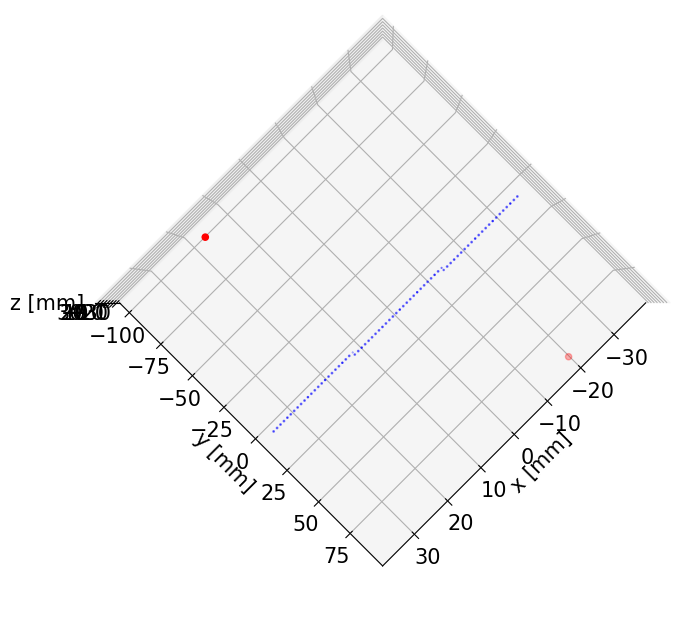

In [368]:
i = 0

m = sm(i, i+1)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=90., azim=45.)
ax.scatter(*[a[i, [k, k+3]] for k in range(3)], color='r')
ax.scatter(X_pixels.flatten(), Z_pixels.flatten(), Y_pixels.flatten(), color='b', s=m.flatten(), alpha=0.5)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png')

plt.show()

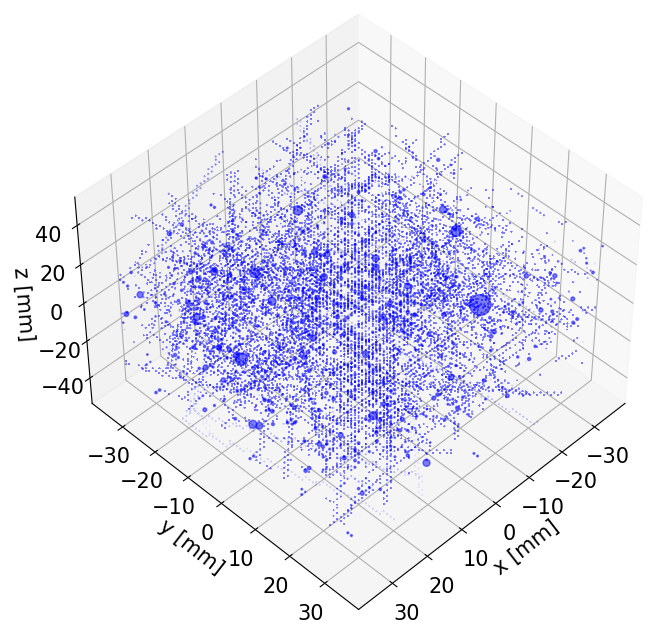

In [349]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=45.)
ax.scatter(X_pixels.flatten(), Y_pixels.flatten(), Z_pixels.flatten(), color='b', s=f_list[-1], alpha=0.5)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')
# fig.savefig('.png')

plt.show()